Titanic Dataset:

Goal: Predicting Survived

Dataset: Pclass, Name, Sex, Age, SibSp - Siblings, Parch - Parents with kids, Ticket, Fare, Embarked - destination embarked, Q,S,C

In [34]:
import sklearn
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure|
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [35]:
#data exploration
data = pd.read_csv('C:/Users/16073/MLPractice/Notebooks/TitanicDataset/input/titanic.csv', delimiter=',', nrows = None)
print(data)

     PassengerId  Survived  Pclass  \
0            892         0       3   
1            893         1       3   
2            894         0       2   
3            895         0       3   
4            896         1       3   
..           ...       ...     ...   
413         1305         0       3   
414         1306         1       1   
415         1307         0       3   
416         1308         0       3   
417         1309         0       3   

                                             Name     Sex   Age  SibSp  Parch  \
0                                Kelly, Mr. James    male  34.5      0      0   
1                Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                       Myles, Mr. Thomas Francis    male  62.0      0      0   
3                                Wirz, Mr. Albert    male  27.0      0      0   
4    Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   
..                                            ...     ...

In [36]:
#remove data that has no use for machine learning - ex. ticket number
data = data.drop(columns=['Name', 'PassengerId', 'Ticket'])
print(data)

     Survived  Pclass     Sex   Age  SibSp  Parch      Fare Cabin Embarked
0           0       3    male  34.5      0      0    7.8292   NaN        Q
1           1       3  female  47.0      1      0    7.0000   NaN        S
2           0       2    male  62.0      0      0    9.6875   NaN        Q
3           0       3    male  27.0      0      0    8.6625   NaN        S
4           1       3  female  22.0      1      1   12.2875   NaN        S
..        ...     ...     ...   ...    ...    ...       ...   ...      ...
413         0       3    male   NaN      0      0    8.0500   NaN        S
414         1       1  female  39.0      0      0  108.9000  C105        C
415         0       3    male  38.5      0      0    7.2500   NaN        S
416         0       3    male   NaN      0      0    8.0500   NaN        S
417         0       3    male   NaN      1      1   22.3583   NaN        C

[418 rows x 9 columns]


In [37]:
# Calculate missing percentage
null_percentage = data.isnull().mean() * 100
print(null_percentage)

# Drop columns with more than 75% missing values
data_cleaned = data.drop(columns=null_percentage[null_percentage > 75].index)
print(data_cleaned)


Survived     0.000000
Pclass       0.000000
Sex          0.000000
Age         20.574163
SibSp        0.000000
Parch        0.000000
Fare         0.239234
Cabin       78.229665
Embarked     0.000000
dtype: float64
     Survived  Pclass     Sex   Age  SibSp  Parch      Fare Embarked
0           0       3    male  34.5      0      0    7.8292        Q
1           1       3  female  47.0      1      0    7.0000        S
2           0       2    male  62.0      0      0    9.6875        Q
3           0       3    male  27.0      0      0    8.6625        S
4           1       3  female  22.0      1      1   12.2875        S
..        ...     ...     ...   ...    ...    ...       ...      ...
413         0       3    male   NaN      0      0    8.0500        S
414         1       1  female  39.0      0      0  108.9000        C
415         0       3    male  38.5      0      0    7.2500        S
416         0       3    male   NaN      0      0    8.0500        S
417         0       3    mal

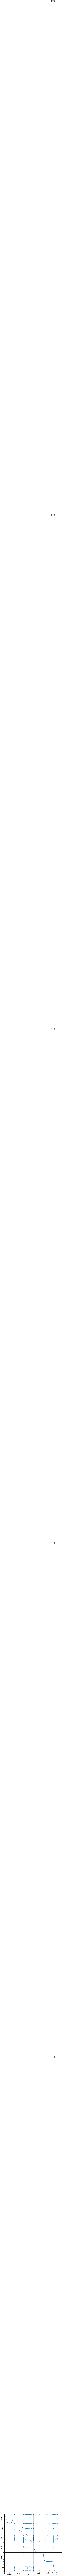

In [38]:
def plotScatterMatrix(df, plotSize, textSize):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from pandas.plotting import scatter_matrix
    
    df = df.select_dtypes(include=[np.number])  # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns where there are more than 1 unique values
    columnNames = list(df)
    
    if len(columnNames) > 10:  # Limit number of columns to avoid overly complex scatter plot
        columnNames = columnNames[:10]
    
    df = df[columnNames]
    
    scatter_matrix(df, alpha=0.75, figsize=(plotSize, plotSize), diagonal='kde')
    corrs = df.corr().values
    
    for i, j in zip(*np.triu_indices_from(corrs, k=1)):
        plt.text(
            i, j, f"{corrs[i, j]:.2f}", 
            ha='center', va='center', 
            fontsize=textSize, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )
    plt.show()

plotScatterMatrix(data_cleaned, 10, 10)

In [39]:

data_cleaned['Fare'].fillna(data_cleaned['Fare'].median(), inplace=True)

from sklearn.preprocessing import MinMaxScaler

# Step 1: Identify rows with null Age values before imputation
rows_with_nulls = data_cleaned[data_cleaned['Age'].isnull()]

# Step 2: Compute the mean and standard deviation of Age and Fare
mean_age = data_cleaned['Age'].mean()
mean_fare = data_cleaned['Fare'].mean()
std_fare = data_cleaned['Fare'].std()

# Step 3: Scale the 'Fare' column
scaler = MinMaxScaler()
data_cleaned['Fare_scaled'] = scaler.fit_transform(data_cleaned[['Fare']])

# Step 4: Impute missing ages dynamically
def impute_age(row, mean_age, mean_fare, std_fare):
    if pd.isnull(row['Age']):
        if row['Fare'] <= 7:  # Extremely cheap fares
            return mean_age * 0.75  # Much younger age (50% of mean_age)
        
        elif row['Fare'] < 25:  # Moderate fares
            fare_deviation = abs(row['Fare'] - mean_fare) / std_fare
            weight_fare = 0.2 + 0.3 * fare_deviation  # Mild adjustment
            return (1 - weight_fare) * mean_age + weight_fare * mean_age * 0.8
        
        else:  # High fares (Fare >= 25)
            fare_deviation = (row['Fare'] - mean_fare) / std_fare
            weight_fare = min(0.5 + 0.5 * fare_deviation**2, 0.9)  # Exponential growth capped at 90%
            return (1 - weight_fare) * mean_age + weight_fare * mean_age * 1.5  # Strong upward adjustment
    
    return row['Age']

data_cleaned['Age'] = data_cleaned.apply(lambda row: impute_age(row, mean_age, mean_fare, std_fare), axis=1)

# Drop the temporary scaled Fare column
data_cleaned.drop(columns=['Fare_scaled'], inplace=True)

if 'Age' in data_cleaned.columns:
    data_cleaned['Age'] = data_cleaned['Age'].apply(lambda x: round(x) if pd.notnull(x) else x)




print(data_cleaned)


     Survived  Pclass     Sex  Age  SibSp  Parch      Fare Embarked
0           0       3    male   34      0      0    7.8292        Q
1           1       3  female   47      1      0    7.0000        S
2           0       2    male   62      0      0    9.6875        Q
3           0       3    male   27      0      0    8.6625        S
4           1       3  female   22      1      1   12.2875        S
..        ...     ...     ...  ...    ...    ...       ...      ...
413         0       3    male   28      0      0    8.0500        S
414         1       1  female   39      0      0  108.9000        C
415         0       3    male   38      0      0    7.2500        S
416         0       3    male   28      0      0    8.0500        S
417         0       3    male   29      1      1   22.3583        C

[418 rows x 8 columns]


C:\Users\16073\AppData\Local\Temp\ipykernel_11108\3098604415.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned['Fare'].fillna(data_cleaned['Fare'].median(), inplace=True)


In [40]:
#take out outliers of fare
print(data_cleaned['Fare'].max())
upper_limit = data_cleaned['Fare'].quantile(0.98)
data_cleaned['Fare'] = data_cleaned['Fare'].clip(upper=upper_limit)
print(data_cleaned['Fare'].max())

512.3292
240.72222799999938


In [41]:
#scale non 0-1 values
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_cleaned[['Fare', 'Age']] = scaler.fit_transform(data_cleaned[['Fare', 'Age']])

In [42]:
print(data_cleaned)


     Survived  Pclass     Sex       Age  SibSp  Parch      Fare Embarked
0           0       3    male  0.306204      0      0 -0.534009        Q
1           1       3  female  1.325136      1      0 -0.550583        S
2           0       2    male  2.500826      0      0 -0.496864        Q
3           0       3    male -0.242451      0      0 -0.517352        S
4           1       3  female -0.634348      1      1 -0.444894        S
..        ...     ...     ...       ...    ...    ...       ...      ...
413         0       3    male -0.164072      0      0 -0.529595        S
414         1       1  female  0.698101      0      0  1.486253        C
415         0       3    male  0.619722      0      0 -0.545586        S
416         0       3    male -0.164072      0      0 -0.529595        S
417         0       3    male -0.085692      1      1 -0.243593        C

[418 rows x 8 columns]


In [43]:
# Map 'Sex' to 0 and 1
data_cleaned['Sex'] = data_cleaned['Sex'].map({'male': 0, 'female': 1})

# Map 'Embarked' to 0, 1, and 2
data_cleaned['Embarked'] = data_cleaned['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Check the updated DataFrame
print(data_cleaned.head())

   Survived  Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
0         0       3    0  0.306204      0      0 -0.534009         2
1         1       3    1  1.325136      1      0 -0.550583         0
2         0       2    0  2.500826      0      0 -0.496864         2
3         0       3    0 -0.242451      0      0 -0.517352         0
4         1       3    1 -0.634348      1      1 -0.444894         0


In [53]:
#shuffle data
data_shuffled = data_cleaned.sample(frac = 1) 

#split it in to train and test data
train_data, test_data = data_shuffled.iloc[:int(len(data_shuffled)*0.3)][['Pclass', 'Sex','Age','SibSp', 'Parch', 'Fare', 'Embarked']], data_shuffled.iloc[int(len(data_shuffled)*0.3):][['Pclass', 'Sex','Age','SibSp', 'Parch', 'Fare', 'Embarked']]
print(train_data)
print(test_data)

train_labels, test_labels = data_shuffled.iloc[:int(len(data_shuffled)*0.3)][['Survived']], data_shuffled.iloc[int(len(data_shuffled)*0.3):][['Survived']]
print(train_labels)
print(test_labels)




     Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
139       3    0  0.776481      1      6  0.246961         0
142       1    0  2.422447      1      3  4.121192         1
360       3    0 -1.261382      8      2  0.699702         0
82        1    0  1.481895      0      0 -0.170800         0
94        1    0 -0.399210      0      0 -0.170800         1
..      ...  ...       ...    ...    ...       ...       ...
316       1    0  2.108929      1      0  2.238239         1
273       3    1 -0.164072      1      0 -0.380680         2
44        1    1  1.168377      1      0  0.359980         0
89        2    0 -2.201935      1      1 -0.230766         0
217       1    0  2.108929      1      1  2.604948         0

[125 rows x 7 columns]
     Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
195       3    0  0.227825      0      0 -0.533509         0
129       3    0 -0.477589      0      0 -0.529595         0
43        2    1 -0.007313      0      0 -0.430652         0


In [57]:
from sklearn.tree import DecisionTreeClassifier
print(DecisionTreeClassifier(max_depth=3).fit(train_data, train_labels).score(test_data, test_labels))


1.0


In [60]:
from sklearn.linear_model import RidgeClassifier
print(RidgeClassifier(alpha=0.7).fit(train_data, train_labels.values.ravel()).score(test_data, test_labels.values.ravel())) #flattens the array

1.0


In [61]:
from sklearn.gaussian_process import GaussianProcessClassifier
model = GaussianProcessClassifier()
model.fit(train_data, train_labels)
print(model.score(test_data, test_labels))

0.9556313993174061


C:\Users\16073\MLPractice\venvs\venv3.12\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
# Update the RidgeClassifier code block
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Create and evaluate the model using cross-validation
ridge_clf = RidgeClassifier(alpha=0.7)
cv_scores = cross_val_score(ridge_clf, train_data, train_labels.values.ravel(), cv=5)

print(f"Cross-validation scores: {cv_scores}")
print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Train on full training set and evaluate on test set
ridge_clf.fit(train_data, train_labels.values.ravel())
test_score = ridge_clf.score(test_data, test_labels.values.ravel())
print(f"Test set score: {test_score:.3f}")

Cross-validation scores: [1. 1. 1. 1. 1.]
Average CV score: 1.000 (+/- 0.000)
Test set score: 1.000


In [64]:
from sklearn.tree import DecisionTreeClassifier

# Create and evaluate the decision tree using cross-validation
dt_clf = DecisionTreeClassifier(max_depth=3)
dt_cv_scores = cross_val_score(dt_clf, train_data, train_labels.values.ravel(), cv=5)

print(f"Cross-validation scores: {dt_cv_scores}")
print(f"Average CV score: {dt_cv_scores.mean():.3f} (+/- {dt_cv_scores.std() * 2:.3f})")

# Train on full training set and evaluate on test set
dt_clf.fit(train_data, train_labels.values.ravel())
dt_test_score = dt_clf.score(test_data, test_labels.values.ravel())
print(f"Test set score: {dt_test_score:.3f}")

Cross-validation scores: [1. 1. 1. 1. 1.]
Average CV score: 1.000 (+/- 0.000)
Test set score: 1.000
